In [1]:
"""
SVM Local Training Notebook
Optimized for local training on your machine (no Colab required)

Parallel Two-Classifier Architecture:
1. Binary: Walk vs Idle (locomotion states - 5s samples)
2. Multi-class: Jump, Punch, Turn_Left, Turn_Right (actions - 1-2s samples)

These run in PARALLEL for simultaneous detection (e.g., walk + jump).

Usage:
    1. Organize your data first: python src/organize_training_data.py
    2. Run this notebook in Jupyter or VS Code
    3. Or run as script: python notebooks/SVM_Local_Training.py
"""

'\nSVM Local Training Notebook\nOptimized for local training on your machine (no Colab required)\n\nParallel Two-Classifier Architecture:\n1. Binary: Walk vs Idle (locomotion states - 5s samples)\n2. Multi-class: Jump, Punch, Turn_Left, Turn_Right (actions - 1-2s samples)\n\nThese run in PARALLEL for simultaneous detection (e.g., walk + jump).\n\nUsage:\n    1. Organize your data first: python src/organize_training_data.py\n    2. Run this notebook in Jupyter or VS Code\n    3. Or run as script: python notebooks/SVM_Local_Training.py\n'

# SVM Local Training - Silksong Gesture Recognition

**Fast Local Training with Support Vector Machines**

This notebook trains SVM models for gesture recognition on your local machine.
No GPU required, training takes 5-15 minutes.

## Setup Requirements:
1. ✅ Organized data in `data/organized_training/`
2. ✅ Python packages: scikit-learn, pandas, numpy, joblib

## Parallel Two-Classifier Architecture:
- **Binary Classifier**: Walk vs Idle (locomotion - 5 second samples)
- **Multi-class Classifier**: Jump, Punch, Turn_Left, Turn_Right (actions - 1-2 second samples)
- **Run in parallel**: Enables walk + jump, walk + punch, etc.

---

## 1. Configuration

In [3]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats
from scipy.fft import fft
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime

# Configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths (adjust if needed)
PROJECT_ROOT = Path(
    "/Users/cvk/Downloads/CODELocalProjects/v3-watch_SilksongController_25TPE/"
)
DATA_DIR = PROJECT_ROOT / "data" / "organized_training"
MODEL_OUTPUT_DIR = PROJECT_ROOT / "models"
MODEL_OUTPUT_DIR.mkdir(exist_ok=True)

# Training mode: 'BINARY', 'MULTICLASS', or 'BOTH'
TRAINING_MODE = "BOTH"  # Train both classifiers

print(f"📂 Project root: {PROJECT_ROOT}")
print(f"📂 Data directory: {DATA_DIR}")
print(f"📂 Model output: {MODEL_OUTPUT_DIR}")
print(f"🎯 Training mode: {TRAINING_MODE}")

📂 Project root: /Users/cvk/Downloads/CODELocalProjects/v3-watch_SilksongController_25TPE
📂 Data directory: /Users/cvk/Downloads/CODELocalProjects/v3-watch_SilksongController_25TPE/data/organized_training
📂 Model output: /Users/cvk/Downloads/CODELocalProjects/v3-watch_SilksongController_25TPE/models
🎯 Training mode: BOTH


## 2. Data Loading

In [4]:
def load_gesture_data(data_path, gestures):
    """
    Load all CSV files for each gesture class.

    Returns:
        List of (DataFrame, label, label_idx) tuples
    """
    all_data = []

    for gesture_idx, gesture in enumerate(gestures):
        gesture_path = data_path / gesture

        if not gesture_path.exists():
            print(f"⚠️  Warning: {gesture} folder not found at {gesture_path}")
            continue

        csv_files = list(gesture_path.glob("*.csv"))

        for csv_file in csv_files:
            try:
                df = pd.read_csv(csv_file)
                all_data.append((df, gesture, gesture_idx))
            except Exception as e:
                print(f"❌ Error loading {csv_file.name}: {e}")

        print(f"✅ Loaded {len(csv_files)} samples for '{gesture}'")

    return all_data


def check_metadata(data_dir):
    """Load and display metadata about organized data."""
    metadata_path = data_dir / "metadata.json"
    if metadata_path.exists():
        with open(metadata_path) as f:
            metadata = json.load(f)
        print("\n📊 Data Organization:")
        print(f"  Total files: {metadata.get('total_files_organized', 'N/A')}")
        print(f"  Binary: {metadata.get('binary_classification', {})}")
        print(f"  Multi-class: {metadata.get('multiclass_classification', {})}")
        print(f"  Noise: {metadata.get('noise_detection', {})}")
        return metadata
    else:
        print("\n⚠️  No metadata.json found")
        return None


# Check metadata
metadata = check_metadata(DATA_DIR)


📊 Data Organization:
  Total files: 228
  Binary: {'description': 'Locomotion states (5s samples) - run in parallel with actions', 'walk': 30, 'idle': 30}
  Multi-class: {'description': 'Action gestures (1-2s samples) - run in parallel with locomotion', 'jump': 30, 'punch': 30, 'turn_left': 30, 'turn_right': 30}
  Noise: {'idle': 30, 'baseline': 48, 'active': 150}


## 3. Feature Engineering

In [5]:
def extract_features_from_dataframe(df):
    """
    Extract comprehensive features from sensor data.

    Features:
    - Time domain: mean, std, min, max, range, median, skew, kurtosis
    - Frequency domain: FFT max, dominant frequency
    - Magnitude features: accel magnitude, gyro magnitude

    Returns:
        dict of features
    """
    features = {}

    # Separate by sensor type
    accel_data = df[df["sensor"] == "linear_acceleration"]
    gyro_data = df[df["sensor"] == "gyroscope"]
    rot_data = df[df["sensor"] == "rotation_vector"]

    def time_features(series, prefix):
        """Extract time-domain features."""
        if len(series) == 0:
            return {}
        return {
            f"{prefix}_mean": np.mean(series),
            f"{prefix}_std": np.std(series),
            f"{prefix}_min": np.min(series),
            f"{prefix}_max": np.max(series),
            f"{prefix}_range": np.max(series) - np.min(series),
            f"{prefix}_median": np.median(series),
            f"{prefix}_skew": stats.skew(series),
            f"{prefix}_kurtosis": stats.kurtosis(series),
        }

    def freq_features(series, prefix):
        """Extract frequency-domain features."""
        if len(series) < 4:
            return {f"{prefix}_fft_max": 0, f"{prefix}_dom_freq": 0}

        fft_vals = np.abs(fft(series))
        return {
            f"{prefix}_fft_max": np.max(fft_vals[: len(fft_vals) // 2]),
            f"{prefix}_dom_freq": np.argmax(fft_vals[: len(fft_vals) // 2]),
        }

    # Accelerometer features
    for axis in ["x", "y", "z"]:
        col = f"accel_{axis}"
        if col in accel_data.columns and len(accel_data) > 0:
            series = accel_data[col].dropna()
            features.update(time_features(series, f"accel_{axis}"))
            features.update(freq_features(series, f"accel_{axis}"))

    # Gyroscope features
    for axis in ["x", "y", "z"]:
        col = f"gyro_{axis}"
        if col in gyro_data.columns and len(gyro_data) > 0:
            series = gyro_data[col].dropna()
            features.update(time_features(series, f"gyro_{axis}"))
            features.update(freq_features(series, f"gyro_{axis}"))

    # Rotation features (quaternion)
    for axis in ["w", "x", "y", "z"]:
        col = f"rot_{axis}"
        if col in rot_data.columns and len(rot_data) > 0:
            series = rot_data[col].dropna()
            features.update(time_features(series, f"rot_{axis}"))

    # Magnitude features
    if len(accel_data) > 0 and all(
        f"accel_{ax}" in accel_data.columns for ax in ["x", "y", "z"]
    ):
        accel_mag = np.sqrt(
            accel_data["accel_x"] ** 2
            + accel_data["accel_y"] ** 2
            + accel_data["accel_z"] ** 2
        )
        features.update(time_features(accel_mag, "accel_mag"))

    if len(gyro_data) > 0 and all(
        f"gyro_{ax}" in gyro_data.columns for ax in ["x", "y", "z"]
    ):
        gyro_mag = np.sqrt(
            gyro_data["gyro_x"] ** 2
            + gyro_data["gyro_y"] ** 2
            + gyro_data["gyro_z"] ** 2
        )
        features.update(time_features(gyro_mag, "gyro_mag"))

    return features


print("✅ Feature extraction function defined")

✅ Feature extraction function defined


## 4. Train Binary Classifier (Walk vs Idle - Locomotion)


BINARY CLASSIFIER: Walk vs Idle (Locomotion)

Loading binary classification data...
✅ Loaded 30 samples for 'walk'
✅ Loaded 30 samples for 'idle'

Extracting features...
  Processed 20/60 samples...
  Processed 40/60 samples...
  Processed 60/60 samples...

✅ Feature extraction complete!
   Shape: (60, 108)
   Features: 108

📊 Class distribution:
   walk: 30 samples
   idle: 30 samples

Train set: 48 samples
Test set: 12 samples

Training SVM (this may take 2-5 minutes)...

✅ Binary SVM training complete!
   Training accuracy: 97.92%
   Test accuracy: 91.67%

Classification Report:
              precision    recall  f1-score   support

        walk       1.00      0.83      0.91         6
        idle       0.86      1.00      0.92         6

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12


💾 Confusion matrix saved to: /Users/cvk/Downloads/CODELocalProjects/v3-watch_Silks

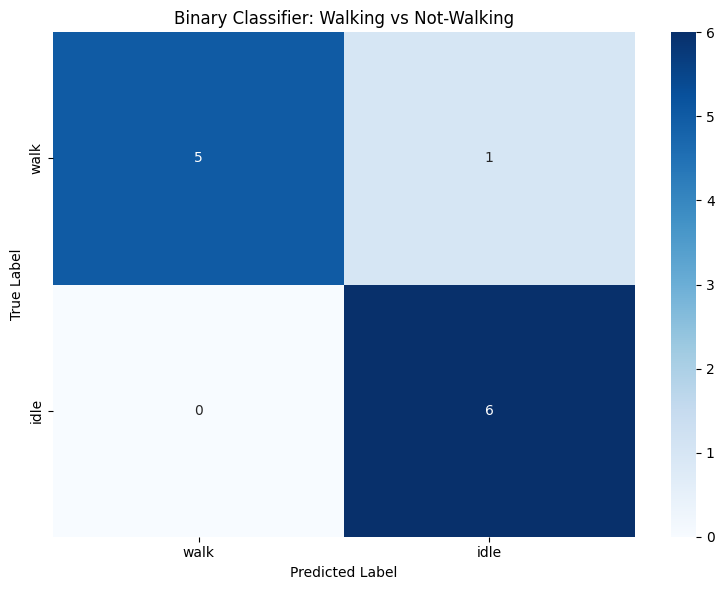


💾 Binary model saved to: /Users/cvk/Downloads/CODELocalProjects/v3-watch_SilksongController_25TPE/models/
   - gesture_classifier_binary.pkl
   - feature_scaler_binary.pkl
   - feature_names_binary.pkl


In [9]:
if TRAINING_MODE in ["BINARY", "BOTH"]:
    print("\n" + "=" * 60)
    print("BINARY CLASSIFIER: Walk vs Idle (Locomotion)")
    print("=" * 60 + "\n")

    # Load binary data
    binary_path = DATA_DIR / "binary_classification"
    binary_gestures = ["walk", "idle"]

    print("Loading binary classification data...")
    binary_data = load_gesture_data(binary_path, binary_gestures)

    # Extract features
    print("\nExtracting features...")
    X_binary_features = []
    y_binary_labels = []

    for i, (df, gesture, gesture_idx) in enumerate(binary_data):
        try:
            features = extract_features_from_dataframe(df)
            X_binary_features.append(features)
            y_binary_labels.append(gesture_idx)

            if (i + 1) % 20 == 0:
                print(f"  Processed {i + 1}/{len(binary_data)} samples...")
        except Exception as e:
            print(f"❌ Error: {e}")

    # Convert to arrays
    X_binary_df = pd.DataFrame(X_binary_features).fillna(0)
    y_binary = np.array(y_binary_labels)

    print(f"\n✅ Feature extraction complete!")
    print(f"   Shape: {X_binary_df.shape}")
    print(f"   Features: {len(X_binary_df.columns)}")

    # Check class distribution
    unique, counts = np.unique(y_binary, return_counts=True)
    print(f"\n📊 Class distribution:")
    for label, count in zip(binary_gestures, counts):
        print(f"   {label}: {count} samples")

    # Split data
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
        X_binary_df,
        y_binary,
        test_size=0.2,
        random_state=RANDOM_SEED,
        stratify=y_binary,
    )

    # Scale features
    scaler_binary = StandardScaler()
    X_train_b_scaled = scaler_binary.fit_transform(X_train_b)
    X_test_b_scaled = scaler_binary.transform(X_test_b)

    print(f"\nTrain set: {X_train_b.shape[0]} samples")
    print(f"Test set: {X_test_b.shape[0]} samples")

    # Train SVM
    print("\nTraining SVM (this may take 2-5 minutes)...")
    svm_binary = SVC(
        kernel="rbf", C=1.0, gamma="scale", random_state=RANDOM_SEED, probability=True
    )
    svm_binary.fit(X_train_b_scaled, y_train_b)

    # Evaluate
    train_acc_b = svm_binary.score(X_train_b_scaled, y_train_b)
    test_acc_b = svm_binary.score(X_test_b_scaled, y_test_b)

    print(f"\n✅ Binary SVM training complete!")
    print(f"   Training accuracy: {train_acc_b:.2%}")
    print(f"   Test accuracy: {test_acc_b:.2%}")

    # Predictions
    y_pred_b = svm_binary.predict(X_test_b_scaled)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test_b, y_pred_b, target_names=binary_gestures))

    # Confusion matrix
    cm_b = confusion_matrix(y_test_b, y_pred_b)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_b,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=binary_gestures,
        yticklabels=binary_gestures,
    )
    plt.title("Binary Classifier: Walking vs Not-Walking")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(MODEL_OUTPUT_DIR / "binary_confusion_matrix.png", dpi=300)
    print(
        f"\n💾 Confusion matrix saved to: {MODEL_OUTPUT_DIR / 'binary_confusion_matrix.png'}"
    )
    plt.show()

    # # Save model
    # timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    # joblib.dump(
    #     svm_binary, MODEL_OUTPUT_DIR / f"gesture_classifier_binary_{timestamp}.pkl"
    # )
    # joblib.dump(
    #     scaler_binary, MODEL_OUTPUT_DIR / f"feature_scaler_binary_{timestamp}.pkl"
    # )
    # joblib.dump(
    #     list(X_binary_df.columns),
    #     MODEL_OUTPUT_DIR / f"feature_names_binary_{timestamp}.pkl",
    # )

    # Also save as default names (for easy loading)
    joblib.dump(svm_binary, MODEL_OUTPUT_DIR / "gesture_classifier_binary.pkl")
    joblib.dump(scaler_binary, MODEL_OUTPUT_DIR / "feature_scaler_binary.pkl")
    joblib.dump(
        list(X_binary_df.columns), MODEL_OUTPUT_DIR / "feature_names_binary.pkl"
    )

    print(f"\n💾 Binary model saved to: {MODEL_OUTPUT_DIR}/")
    print(f"   - gesture_classifier_binary.pkl")
    print(f"   - feature_scaler_binary.pkl")
    print(f"   - feature_names_binary.pkl")

## 5. Train Multi-class Classifier (Jump, Punch, Turn_Left, Turn_Right - Actions)


MULTI-CLASS CLASSIFIER: Actions (Jump, Punch, Turn_Left, Turn_Right)

Loading multi-class data...
✅ Loaded 30 samples for 'jump'
✅ Loaded 30 samples for 'punch'
✅ Loaded 30 samples for 'turn_left'
✅ Loaded 30 samples for 'turn_right'

Extracting features...
  Processed 20/120 samples...
  Processed 40/120 samples...
  Processed 60/120 samples...
  Processed 80/120 samples...
  Processed 100/120 samples...
  Processed 120/120 samples...

✅ Feature extraction complete!
   Shape: (120, 108)
   Features: 108

📊 Class distribution:
   jump: 30 samples
   punch: 30 samples
   turn_left: 30 samples
   turn_right: 30 samples

Train set: 96 samples
Test set: 24 samples

Training SVM (this may take 2-5 minutes)...

✅ Multi-class SVM training complete!
   Training accuracy: 88.54%
   Test accuracy: 58.33%

Classification Report:
              precision    recall  f1-score   support

        jump       0.67      0.33      0.44         6
       punch       0.40      0.33      0.36         6
   tur

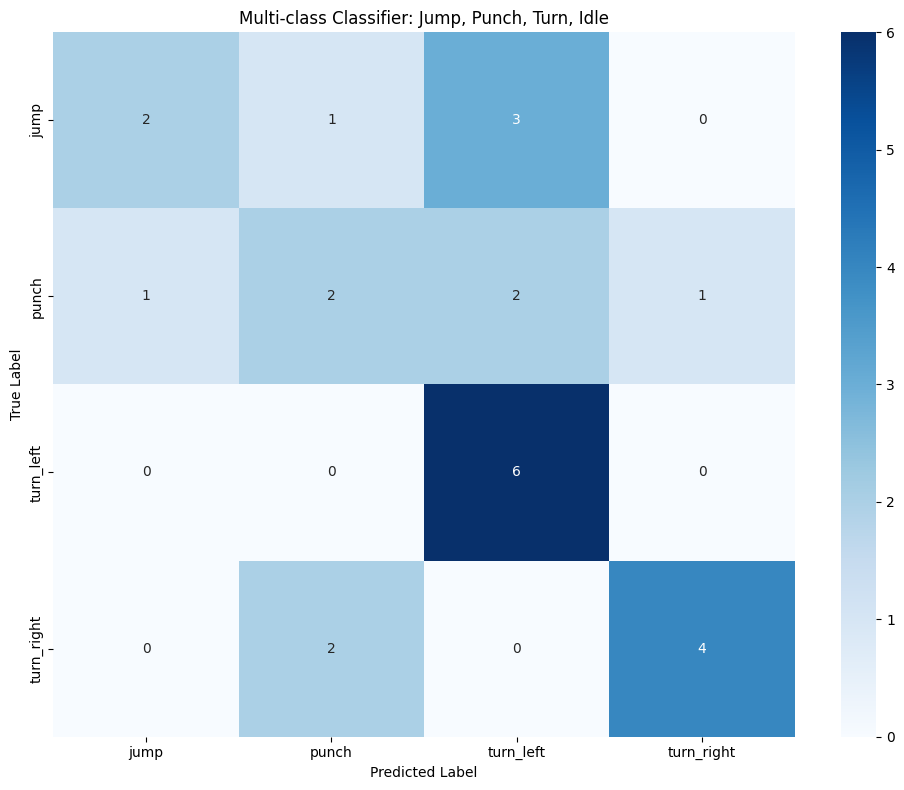


💾 Multi-class model saved to: /Users/cvk/Downloads/CODELocalProjects/v3-watch_SilksongController_25TPE/models/
   - gesture_classifier_multiclass.pkl
   - feature_scaler_multiclass.pkl
   - feature_names_multiclass.pkl


In [ ]:
if TRAINING_MODE in ["MULTICLASS", "BOTH"]:
    print("\n" + "=" * 60)
    print("MULTI-CLASS CLASSIFIER: Actions (Jump, Punch, Turn_Left, Turn_Right)")
    print("=" * 60 + "\n")

    # Load multiclass data
    multiclass_path = DATA_DIR / "multiclass_classification"
    multiclass_gestures = ["jump", "punch", "turn_left", "turn_right"]

    print("Loading multi-class data...")
    multiclass_data = load_gesture_data(multiclass_path, multiclass_gestures)

    # Extract features
    print("\nExtracting features...")
    X_multi_features = []
    y_multi_labels = []

    for i, (df, gesture, gesture_idx) in enumerate(multiclass_data):
        try:
            features = extract_features_from_dataframe(df)
            X_multi_features.append(features)
            y_multi_labels.append(gesture_idx)

            if (i + 1) % 20 == 0:
                print(f"  Processed {i + 1}/{len(multiclass_data)} samples...")
        except Exception as e:
            print(f"❌ Error: {e}")

    # Convert to arrays
    X_multi_df = pd.DataFrame(X_multi_features).fillna(0)
    y_multi = np.array(y_multi_labels)

    print(f"\n✅ Feature extraction complete!")
    print(f"   Shape: {X_multi_df.shape}")
    print(f"   Features: {len(X_multi_df.columns)}")

    # Check class distribution
    unique, counts = np.unique(y_multi, return_counts=True)
    print(f"\n📊 Class distribution:")
    for label, count in zip(multiclass_gestures, counts):
        print(f"   {label}: {count} samples")

    # Warn about imbalance
    max_count = max(counts)
    min_count = min(counts)
    if max_count > min_count * 1.3:
        print(f"\n⚠️  Warning: Class imbalance (ratio: {max_count/min_count:.2f}x)")
        print(f"   Consider collecting more data for minority classes")

    # Split data
    X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
        X_multi_df, y_multi, test_size=0.2, random_state=RANDOM_SEED, stratify=y_multi
    )

    # Scale features
    scaler_multi = StandardScaler()
    X_train_m_scaled = scaler_multi.fit_transform(X_train_m)
    X_test_m_scaled = scaler_multi.transform(X_test_m)

    print(f"\nTrain set: {X_train_m.shape[0]} samples")
    print(f"Test set: {X_test_m.shape[0]} samples")

    # Train SVM
    print("\nTraining SVM (this may take 2-5 minutes)...")
    svm_multi = SVC(
        kernel="rbf", C=1.0, gamma="scale", random_state=RANDOM_SEED, probability=True
    )
    svm_multi.fit(X_train_m_scaled, y_train_m)

    # Evaluate
    train_acc_m = svm_multi.score(X_train_m_scaled, y_train_m)
    test_acc_m = svm_multi.score(X_test_m_scaled, y_test_m)

    print(f"\n✅ Multi-class SVM training complete!")
    print(f"   Training accuracy: {train_acc_m:.2%}")
    print(f"   Test accuracy: {test_acc_m:.2%}")

    # Predictions
    y_pred_m = svm_multi.predict(X_test_m_scaled)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test_m, y_pred_m, target_names=multiclass_gestures))

    # Confusion matrix
    cm_m = confusion_matrix(y_test_m, y_pred_m)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_m,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=multiclass_gestures,
        yticklabels=multiclass_gestures,
    )
    plt.title("Multi-class Classifier: Jump, Punch, Turn, Idle")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(MODEL_OUTPUT_DIR / "multiclass_confusion_matrix.png", dpi=300)
    print(
        f"\n💾 Confusion matrix saved to: {MODEL_OUTPUT_DIR / 'multiclass_confusion_matrix.png'}"
    )
    plt.show()

    # # Save model
    # timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    # joblib.dump(
    #     svm_multi, MODEL_OUTPUT_DIR / f"gesture_classifier_multiclass_{timestamp}.pkl"
    # )
    # joblib.dump(
    #     scaler_multi, MODEL_OUTPUT_DIR / f"feature_scaler_multiclass_{timestamp}.pkl"
    # )
    # joblib.dump(
    #     list(X_multi_df.columns),
    #     MODEL_OUTPUT_DIR / f"feature_names_multiclass_{timestamp}.pkl",
    # )

    # Also save as default names
    joblib.dump(svm_multi, MODEL_OUTPUT_DIR / "gesture_classifier_multiclass.pkl")
    joblib.dump(scaler_multi, MODEL_OUTPUT_DIR / "feature_scaler_multiclass.pkl")
    joblib.dump(
        list(X_multi_df.columns), MODEL_OUTPUT_DIR / "feature_names_multiclass.pkl"
    )

    print(f"\n💾 Multi-class model saved to: {MODEL_OUTPUT_DIR}/")
    print(f"   - gesture_classifier_multiclass.pkl")
    print(f"   - feature_scaler_multiclass.pkl")
    print(f"   - feature_names_multiclass.pkl")

## 6. Summary

In [ ]:
print("\n" + "=" * 60)
print("🎉 TRAINING COMPLETE!")
print("=" * 60)

if TRAINING_MODE in ["BINARY", "BOTH"]:
    print(f"\n📊 Binary Classifier (Walk vs Idle - Locomotion):")
    print(f"   Test Accuracy: {test_acc_b:.2%}")
    print(f"   Model: models/gesture_classifier_binary.pkl")

if TRAINING_MODE in ["MULTICLASS", "BOTH"]:
    print(
        f"\n📊 Multi-class Classifier (Jump, Punch, Turn_Left, Turn_Right - Actions):"
    )
    print(f"   Test Accuracy: {test_acc_m:.2%}")
    print(f"   Model: models/gesture_classifier_multiclass.pkl")

print(f"\n✨ Next Steps:")
print(f"   1. Test models with: python src/udp_listener.py")
print(f"   2. Models are in: {MODEL_OUTPUT_DIR}/")
print(f"   3. Update controller to use parallel classification")

print(f"\n💡 Parallel Controller Logic:")
print(f"   Thread 1: Run binary classifier (walk vs idle)")
print(f"   Thread 2: Run multi-class classifier (jump/punch/turn_left/turn_right)")
print(f"   Combine: Execute locomotion + action simultaneously")
print(f"   Examples: walk + jump, idle + punch, walk + turn_left")